# Chapter 3: Text Embeddings

## 3.1 Embeddings

Embeddings are procedures that turn input data into vectors.  Recall from chapter 1 that there are 2 kinds:
* Representational embeddings are designed by hand and thus human-interpretable.
* Operational embeddings are learned from data

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import codecs
import re

Using TensorFlow backend.


### 3.1.1 Embed by Hand: Representational Embeddings
**one-hot embeddings**
Every element of this vector embedding is zero, except at a single meaningful index.
<img src="images/oneHot.png/">

Given the embedding above:
The word _cat_ is represented by the vector $ [0, 1, 0, 0, 0, 0 ]$
The word _sat_ is represented by the vector $ [0, 0, 1, 0,0, 0, ]$


In [2]:
def one_hot(lexicon, word):
    '''


    :param lexicon: A sentence string
    :param word: a string
    :return: np.array one-hot vector representing the word from the given lexicon
    '''
    lexicon = np.array(lexicon.split(' ')) # split sentence into words
    return np.multiply(lexicon == word, 1) # multiply turns True/False into integers 1, 0

lex = 'want to go swim at the beach'

one_hot(lex, 'beach' )

array([0, 0, 0, 0, 0, 0, 1])

Ideally, words that are related to each other will generally lie close to each other in vector space, but note below that there spatial distance does not make sense from a linguistic perspective since different one-hot vectors only differ by just one bit.
As such one-hot embeddings are used when distance-based similarity does not come into play.

In [ ]:
a = one_hot(lex, 'beach')
b = one_hot(lex, 'swim')
c = one_hot(lex, 'want')
print(f'distance between \"beach\" and \"swim\": {np.linalg.norm(a - b)}')
print(f'distance between \"beach\" and \"want\": {np.linalg.norm(a - c)}')


### 3.1.1 Learning to Embed: Procedural embeddings
Keras Embeddings layers deploy a matrix of weights that are optimized (like a mini single layer network) using a loss function.
The implicit, default loss function is one that maximizes the distinctiveness of vector representations.

The embedding below generates, for every array of 10 integers (a row in the input matrix), a 10x8 matrix consisting of 8-dimensional values, one for every integer in the integer array.


In [5]:

model = Sequential() # create the model container
model.add(Embedding(input_dim=100, output_dim=8, input_length=10))   # add an embedding for 100 integers, arranged in blocks of 10
input_array = np.random.randint(100, size=(10, 10)) # a random input
model.compile('rmsprop', 'mse') # “compile the model, setting the loss function to 'mean squared error', and using the rmsprop optimizer. ”
output_array = model.predict(input_array) # generate embeddings
print(f'input dim: {input_array.shape}')
print(f'output dim: {output_array.shape}')

input dim: (10, 10)
output dim: (10, 10, 8)


Applied to text, we can represent a set of documents as a vector of integers and create a standard embedding of these documents in a similar way

In [3]:

docs=["Chuck Berry rolled over everyone who came before him ? and turned up everyone who came after. We'll miss you",
      "Help protect the progress we've made in helping millions of Americans get covered.",
      "Let's leave our children and grandchildren a planet that's healthier than the one we have today.",
      "The American people are waiting for Senate leaders to do their jobs.",
      "We must take bold steps now ? climate change is already impacting millions of people.",
      "Don't forget to watch Larry King tonight",
      "Ivanka is now on Twitter - You can follow her",
      "Last night Melania and I attended the Skating with the Stars Gala at Wollman Rink in Central Park",
      "People who have the ability to work should. But with the government happy to send checks",
      "I will be signing copies of my new book"]

docs=[d.lower() for d in docs] # make everything lower case

count_vect = CountVectorizer().fit(docs) # maps every word to a unique arbitrary integer from the vocabulary
tokenizer = count_vect.build_tokenizer() # initialize a tokenizer

print(count_vect.vocabulary_)



input_array=[]
for doc in docs:
    x=[]
    for token in tokenizer(doc): #tokenizer(doc) just splits the string on white spaces to get a list of word strings
        x.append(count_vect.vocabulary_.get(token)) # get the integer from the vocabulary assigned to each word in the doc
    input_array.append(x)


max_len=max([len(d) for d in input_array]) # max length of document
input_array=pad_sequences(input_array, maxlen=max_len, padding='post') # pad with zeros so all vectors are the same length


{'chuck': 21, 'berry': 11, 'rolled': 74, 'over': 67, 'everyone': 27, 'who': 97, 'came': 15, 'before': 10, 'him': 41, 'and': 5, 'turned': 90, 'up': 92, 'after': 1, 'we': 96, 'll': 53, 'miss': 57, 'you': 102, 'help': 38, 'protect': 72, 'the': 85, 'progress': 71, 've': 93, 'made': 54, 'in': 43, 'helping': 39, 'millions': 56, 'of': 63, 'americans': 4, 'get': 32, 'covered': 24, 'let': 52, 'leave': 51, 'our': 66, 'children': 20, 'grandchildren': 34, 'planet': 70, 'that': 84, 'healthier': 37, 'than': 83, 'one': 65, 'have': 36, 'today': 88, 'american': 3, 'people': 69, 'are': 6, 'waiting': 94, 'for': 29, 'senate': 75, 'leaders': 50, 'to': 87, 'do': 25, 'their': 86, 'jobs': 46, 'must': 58, 'take': 82, 'bold': 12, 'steps': 81, 'now': 62, 'climate': 22, 'change': 18, 'is': 44, 'already': 2, 'impacting': 42, 'don': 26, 'forget': 30, 'watch': 95, 'larry': 48, 'king': 47, 'tonight': 89, 'ivanka': 45, 'on': 64, 'twitter': 91, 'can': 16, 'follow': 28, 'her': 40, 'last': 49, 'night': 61, 'melania': 55,

We can visualize the vector embeddings with the well-known visualization algorithm T-SNE (MaatenHinton2008). This algorithm maps high-dimensional vectors to lower-dimensional planes.

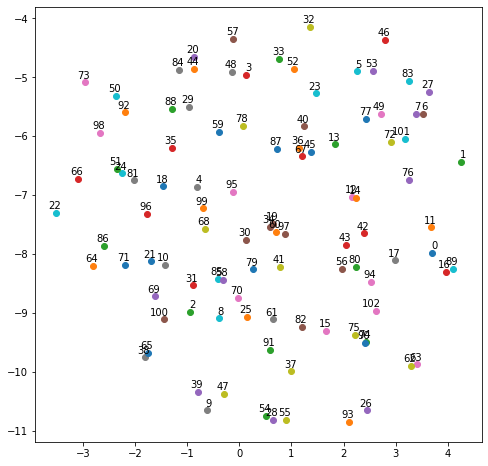

In [4]:
def tsne_plot(model,max_words=200):
    labels = []
    tokens = []

    n=0
    for word in model:
        if n<max_words:
            tokens.append(model[word])
            labels.append(word)
            n+=1


    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=10000, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(8, 8))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

model = Sequential()
model.add(Embedding(200, 8, input_length=20))
#input_array = np.random.randint(100, size=(10, 10))
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)

M={}
for i in range(len(input_array)):
    for j in range(len(input_array[i])):
        M[input_array[i][j]]=output_array[i][j]

tsne_plot(M)

 - so a lexicon is represented by a vocabulary that maps words to integers.
 - a single word is represented by an _integer_.
 - each _integer_ is then represented by the output of `model.predict()`, which gives an 8-dimensional array
So each word is represented by this 8-dim vector in model output space.

Note that spatial distance in the plot above does not reflect any semantic differences because our choice of optimizer `(rmsprop)` for the Embed layer didn't account for this.

**Training a word embedding**

with training of the Embedding layer, words should be vectorized such that _they contribute maximally to discerning documents with positive sentiment from those with negative sentiment._
In other words, the word embeddings that are learned are optimized in the context of a specific task.

**Optimization of a Keras embedding.**

A vector of integers (representing a set of documents) where each integer corresponds to a word string. Similar to the case above with random integers, but now we can add labels to denote positive and negative sentiment.
We now train a word embedding constrained by a loss function that aims for _maximum separation of the documents_.
Note that the difference between the cell above and a trained embedding layer is the addition of a loss function that aims to maximize discriminability of the documents.

In [10]:
count_vect.vocabulary_
print(list(count_vect.vocabulary_.keys())[list(count_vect.vocabulary_.values()).index(96)])


we


In [9]:
'''
import pandas as pd
data = pd.read_csv('../Data/Restaurant_Reviews.tsv', sep='\t',  encoding = "ISO-8859-1")
data.iloc[:700].to_csv('../Data/RestaurantReviews_training.tsv', sep='\t', index=False, header=False)
data.iloc[700:].to_csv('../Data/RestaurantReviews_test.tsv', sep='\t', index=False, header=False)
'''

In [7]:

def save_embedding(outputFile, weights, vocabulary):
    '''
    This function saves a text file containing each word in the vocabulary and the embedding weights that were learned in the model.

    :param outputFile:
    :param weights:
    :param vocabulary:
    :return:
    '''
    rev = {v:k for k, v in vocabulary.items()} # reverses the dictionary from words --> integer to go from integer --> words
    with codecs.open(outputFile, "w") as f:
        f.write(str(len(vocabulary)) + " " + str(weights.shape[1]) + "\n")
        for index in sorted(rev.keys()):
            word=rev[index]
            f.write(word + " ")
            for i in range(len(weights[index])):
                f.write(str(weights[index][i]) + " ")
            f.write("\n")


def getLines(f):
    ''' Given a path to a .tsv file, this function returns a list of strings corresponding to each row of the .tsv file.
    Columns are joined together in a single string per row separated by \t (denoting a tab) '''
    lines = [line.rstrip() for line in open(f)]
    return lines



def create_vocabulary(vocabulary, sentences):
    '''

    :param vocabulary: an empty dictionary
    :param sentences: a list of strings representing the rows of the .tsv file containing restaurant review data
    :return: a dictionary mapping every unique word in the sentences list, to an integer
    '''
    vocabulary["<unk>"]=0
    for sentence in sentences: #for each row in the .tsv data file
        for word in sentence.strip().split(): # each row is a string that is split into a list of words
            word=re.sub("[.,:;'\"!?()]+","",word.lower()) # replace special characters with nothing, and make all words lowercase
            if word not in vocabulary: # make sure each word is unique
                vocabulary[word]=len(vocabulary) # assign an integer to the word


def process_training_data(textFile,max_len):
    data=[]
    sentences = getLines(textFile) # a list of strings where each string corresponds to a row from the input textfile.
    vocab = dict()
    labels=[]
    create_vocabulary(vocab, sentences) # a dictionary mapping every unique word in the sentences list, to an integer
    for s in sentences: # each s in sentences is one string consisting of a review AND a boolean label of positive or negative.
        words=[]
        m=re.match("^([^\t]+)\t(.+)$",s.rstrip())  # searches the string for a "\t"
        if m:
            sentence=m.group(1) # first group is the text of the review (before the "\t")
            labels.append(int(m.group(2))) # second group (comes after \t of the string, s) is the label
            for w in sentence.split(" "):
                w=re.sub("[.,:;'\"!?()]+","",w.lower()) # removes special characters, and makes everything lowercase
                if w!='': # if there are words left
                    words.append(vocab[w]) # append the integer from the vocabulary that represents word, w.
        data.append(words)
    data = pad_sequences(data, maxlen=max_len, padding='post') # pad with zeros so vectors are all the same length

    return data,labels, vocab


def process_test_data(textFile,vocab,max_len):
    data=[]
    sentences = getLines(textFile) # a list of strings where each string corresponds to a row from the input textfile.
    labels=[]
    create_vocabulary(vocab, sentences) # a dictionary mapping every unique word in the sentences list, to an integer
    for s in sentences: # each s in sentences is one string consisting of a review AND a boolean label of positive or negative.
        words=[]
        m=re.match("^([^\t]+)\t(.+)$",s.rstrip()) # searches the string for a "\t"
        if m:
            sentence=m.group(1) # first group is the text of the review (before the "\t")
            labels.append(int(m.group(2))) # second group (comes after \t of the string, s) is the label
            for w in sentence.split(" "):
                w=re.sub("[.,:;'\"!?()]+","",w.lower()) # removes special characters, and makes everything lowercase
                if w!='': # if there are words left
                    if w in vocab:
                        words.append(vocab[w]) # append the integer from the vocabulary that represents word, w.
                    else:
                        words.append(vocab["<unk>"])
        data.append(words)
    data = pad_sequences(data, maxlen=max_len, padding='post')
    return data,labels




In [14]:

train_dat_path = '../Data/RestaurantReviews_training.tsv'
test_dat_path = '../Data/RestaurantReviews_test.tsv'

max_len=100
data,labels,vocab=process_training_data(train_dat_path, max_len)
test_data,test_labels=process_test_data(test_dat_path,vocab,max_len)

model = Sequential()
embedding=Embedding(len(vocab), 100, input_length=max_len)
model.add(embedding)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['acc'])
model.fit(data,labels,epochs=100, verbose=1)

loss, accuracy = model.evaluate(test_data, test_labels, verbose=0)
print(accuracy)

save_embedding("embedding_labeled.txt", embedding.get_weights()[0], vocab)



/Users/bryangonzalez/opt/anaconda3/envs/mTurkBx/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
700/700 [==============================] - 1s 1ms/step - loss: 0.6904 - acc: 0.5643
Epoch 2/100
700/700 [==============================] - 0s 410us/step - loss: 0.6721 - acc: 0.5557
Epoch 3/100
700/700 [==============================] - 0s 354us/step - loss: 0.6296 - acc: 0.7100
Epoch 4/100
700/700 [==============================] - 0s 316us/step - loss: 0.5645 - acc: 0.7800
Epoch 5/100
700/700 [==============================] - 0s 319us/step - loss: 0.4740 - acc: 0.8871
Epoch 6/100
700/700 [==============================] - 0s 333us/step - loss: 0.3745 - acc: 0.9314
Epoch 7/100
700/700 [==============================] - 0s 325us/step - loss: 0.2874 - acc: 0.9743
Epoch 8/100
700/700 [==============================] - 0s 323us/step - loss: 0.2156 - acc: 0.9829
Epoch 9/100
700/700 [==============================] - 0s 336us/step - loss: 0.1648 - acc: 0.9900
Epoch 10/100
700/700 [==============================] - 0s 303us/step - loss: 0.1280 - acc: 0.9929
Epoch 11/100
700/700 

AttributeError: 'dict' object has no attribute 'iteritems'

Now that we have learned embeddings for each word in the vocabulary, we can look at nearest neighbors

In [ ]:
from gensim.models import KeyedVectors # gensime is a topic modeling package
import gensim.models
import os

w2v = gensim.models.KeyedVectors.load_word2vec_format('embedding_labeled.txt', binary=False, unicode_errors='ignore')

for w in  sorted(w2v.wv.vocab):
    print(w,w2v.most_similar(w,topn=3))

## 3.2 From Words to Vectors: word2vec

The Word2Vec algorithm is a procedural (learned) embedding. The vector representations of words obtained with Word2Vec express similarities between words based on their context: the words that share similar contexts end up having similar numerical vector representations.

In our example, we wll use Word2Vec to predict contexts from words, in order to build a tool that suggests synonyms in an editor. For instance, given a string like “the restaurant has a terrible ambiance and the food is awful” we want to predict if the words ‘terrible’ for ‘restaurant’ and ‘awful’ for ‘food’ are valid context words.

To do that, we need both positive and negative examples of surrounding contexts. To get negative examples, we use the procedure called “negative sampling”. First, we map words to integers. Second, using a random generator and a fixed context window size, we sample positive examples, as well as negative ones. This produces couples of integers (input word, context word) and associated labels - 0 for an invalid context and 1 for a valid one.

In [ ]:
from keras.preprocessing.sequence import skipgrams

sentence = "the restaurant has a terrible ambiance and the food is awful"
sequence=[vocab[w] for w in sentence.split(" ")]
vocab = dict()
create_vocabulary(vocab, sentence)
skipgrams(sequence, 100, window_size=3)

# Processing data for Word2Vec.

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Reshape, dot
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing import sequence

import numpy as np
import sys

import random
import re
import codecs

def save_embeddings(save_filepath, weights, vocabulary):
        rev = {v:k for k, v in vocabulary.items()}
        with codecs.open(save_filepath, "w") as f:
            f.write(str(len(vocabulary)) + " " + str(weights.shape[1]) + "\n")
            for index in sorted(rev.keys()):
                word=rev[index]
                f.write(word + " ")
                for i in range(len(weights[index])):
                    f.write(str(weights[index][i]) + " ")
                    f.write("\n")


def getLines(f):
    lines = [line.rstrip() for line in open(f)]
    return lines


# a function that loops over skipgrams (created by process_data function below) during the training phase of the model,
# picking out random samples and labels and feeding them as batches to the model.
def generator(target,context, labels, batch_size):
    batch_target = np.zeros((batch_size, 1))
    batch_context = np.zeros((batch_size, 1))
    batch_labels = np.zeros((batch_size,1))

    while True:
        for i in range(batch_size):
            index= random.randint(0,len(target)-1)
            batch_target[i] = target[index]
            batch_context[i]=context[index]
            batch_labels[i] = labels[index]
        yield [batch_target,batch_context], [batch_labels]

# a function for processing raw data (plain sentences) for skipgrams, and collecting all skupgrams and their labels for the entire dataset
def process_data(textFile,window_size):
    couples=[] # for pairs of words: input word and context word
    labels=[] # for their labels
    sentences = getLines(textFile)
    vocab = dict()
    create_vocabulary(vocab, sentences)
    vocab_size=len(vocab)
    for s in sentences:
        words=[]
        for w in s.split(" "):
            w=re.sub("[.,:;'\"!?()]+","",w.lower())
            if w!='':
                words.append(vocab[w])
        c,l=skipgrams(words,vocab_size,window_size=window_size) # creating skupgrams - word pairs with corresponding labels.
        couples.extend(c)
        labels.extend(l)
    return vocab,couples,labels


def  create_vocabulary(vocabulary, sentences):
    vocabulary["<unk>"]=0
    for sentence in sentences:
        for word in sentence.strip().split():
            word=re.sub("[.,:;'\"!?()]+","",word.lower())
            if word not in vocabulary:
                vocabulary[word]=len(vocabulary)


window_size = 3
vector_dim = 100
epochs = 1000


file_path = 'embedding_labeled.txt'
vocab,couples,labels=process_data(file_path,window_size)

vocab_size=len(vocab)

# Splitting the generated couples into the target words (input) and the context words.
word_target, word_context = zip(*couples)
word_target = np.array(word_target, dtype="int32")
word_context = np.array(word_context, dtype="int32")

# Targets and contexts consist of one-dimensional input layers.
input_target = Input((1,))
input_context = Input((1,))

# Our embedding accepts inputs of size 1 and maps them to vectors of size vector_dim, and does it for a total of vocab_size different words.
embedding = Embedding(vocab_size, vector_dim, input_length=1, name='embedding')
# Embedding the targets and reshaping them to the desired vector length.
target = embedding(input_target)
target = Reshape((vector_dim, 1))(target)
# Embedding the contexts and reshaping them to the desired vector length.
context = embedding(input_context)
context = Reshape((vector_dim, 1))(context)

# Calculating the dot product of the target and context vectors. This dot product is an intermediate representation upon which the final classification (whether for a given target word the context word is valid or not).
dot_product = dot([target, context], axes=1)
dot_product = Reshape((1,))(dot_product)
output = Dense(1, activation='sigmoid')(dot_product)
model = Model(input=[input_target, input_context], output=output)
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['acc'])

print(model.summary())

epochs=int(1)

# Feeding random batches (100 cases each) of target words, context words and labels, for 1000 epochs. Every epoch carries 100 optimization steps.
model.fit_generator(generator(word_target, word_context,labels,100), steps_per_epoch=100, epochs=epochs)

#Extracting the per-word weights from the shared embedding. These weights constitute the Word2Vec embedding for the input words.
save_embeddings("embedding.txt", embedding.get_weights()[0], vocab)

exit(0)

In [ ]:
# These are my Lovely Additions I really know Deep Learning and NLP and Github. Please hire/save me

## 3.3 From Documents to Vector: doc2vec

a random thing